In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [2]:
!pip install contractions

     |████████████████████████████████| 327kB 7.0MB/s 
     |████████████████████████████████| 286kB 33.0MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.2-cp37-cp37m-linux_x86_64.whl size=85409 sha256=fa2ab9dd1874e46420f2e2d28f3e5f83fb03c88e4d683ff6f9d1c879802bf788
  Stored in directory: /root/.cache/pip/wheels/3a/03/34/77e3ece0bba8b86bfac88a79f923b36d805cad63caeba38842
Successfully built pyahocorasick


In [3]:
import os
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import string
import re
import nltk
import contractions
import torch
import torch.nn as nn
import torchtext.legacy.data as ttd
from torchtext.vocab import Vectors, GloVe
from torch.autograd import Variable
from torch.nn import functional as F
from datetime import datetime
import time

#Cleaning

In [5]:
train_df = pd.read_csv('/content/gdrive/My Drive/SBU/NN/04/train.csv')
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [6]:
display(train_df[~train_df["location"].isnull()].head())
display(train_df[train_df["target"] == 0]["text"].values[1])
display(train_df[train_df["target"] == 1]["text"].values[1])

,id,keyword,location,text,target
31,48,ablaze,Birmingham,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1
32,49,ablaze,Est. September 2012 - Bristol,We always try to bring the heavy. #metal #RT h...,0
33,50,ablaze,AFRICA,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1
34,52,ablaze,"Philadelphia, PA",Crying out for more! Set me ablaze,0
35,53,ablaze,"London, UK",On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0


'I love fruits'

'Forest fire near La Ronge Sask. Canada'

In [7]:
def remove_special_characters(text):
    """
        Remove special special characters, including symbols, emojis, and other graphic characters
    """
    emoji_pattern = re.compile(
        '['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [8]:
train_df["text_clean"] = train_df["text"].apply(lambda x: remove_special_characters(x))

In [9]:
train_df["text_clean"] = train_df["text_clean"].apply(lambda x: contractions.fix(x))
print(train_df["text"][7])
print(train_df["text_clean"][7])

I'm on top of the hill and I can see a fire in the woods...
I am on top of the hill and I can see a fire in the woods...


In [10]:
train_df["text_clean"] = train_df["text"].apply(lambda x: x.lower())
train_df.head()

,id,keyword,location,text,target,text_clean
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,our deeds are the reason of this #earthquake m...
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask. canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,all residents asked to 'shelter in place' are ...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,"13,000 people receive #wildfires evacuation or..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,just got sent this photo from ruby #alaska as ...


In [11]:
def remove_URL(text):
    """
        Remove URLs from a sample string
    """
    return re.sub(r"https?://\S+|www\.\S+", "", text)

In [12]:
train_df["text_clean"] = train_df["text_clean"].apply(lambda x: remove_URL(x))

print(train_df["text"][31])
print(train_df["text_clean"][31])

@bbcmtd Wholesale Markets ablaze http://t.co/lHYXEOHY6C
@bbcmtd wholesale markets ablaze 


In [13]:
def remove_html(text):
    """
        Remove the html in sample text
    """
    html = re.compile(r"<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});")
    return re.sub(html, "", text)

In [14]:
train_df["text_clean"] = train_df["text_clean"].apply(lambda x: remove_html(x))

print(train_df["text"][62])
print(train_df["text_clean"][62])

Rene Ablaze &amp; Jacinta - Secret 2k13 (Fallen Skies Edit) - Mar 30 2013  https://t.co/7MLMsUzV1Z
rene ablaze  jacinta - secret 2k13 (fallen skies edit) - mar 30 2013  


In [15]:
def remove_non_ascii(text):
    """
        Remove non-ASCII characters 
    """
    return re.sub(r'[^\x00-\x7f]',r'', text)

In [16]:
train_df["text_clean"] = train_df["text_clean"].apply(lambda x: remove_non_ascii(x))

print(train_df["text"][38])
print(train_df["text_clean"][38])

Barbados #Bridgetown JAMAICA ÛÒ Two cars set ablaze: SANTA CRUZ ÛÓ Head of the St Elizabeth Police Superintende...  http://t.co/wDUEaj8Q4J
barbados #bridgetown jamaica  two cars set ablaze: santa cruz  head of the st elizabeth police superintende...  


In [17]:
def remove_punct(text):
    """
        Remove the punctuation
    """
#     return re.sub(r'[]!"$%&\'()*+,./:;=#@?[\\^_`{|}~-]+', "", text)
    return text.translate(str.maketrans('', '', string.punctuation))

In [18]:
train_df["text_clean"] = train_df["text_clean"].apply(lambda x: remove_punct(x))

print(train_df["text"][5])
print(train_df["text_clean"][5])

#RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires
rockyfire update  california hwy 20 closed in both directions due to lake county fire  cafire wildfires


In [19]:
def other_clean(text):
        """
            Other manual text cleaning techniques
        """
        # Typos, slang and other
        sample_typos_slang = {
                                "w/e": "whatever",
                                "usagov": "usa government",
                                "recentlu": "recently",
                                "ph0tos": "photos",
                                "amirite": "am i right",
                                "exp0sed": "exposed",
                                "<3": "love",
                                "luv": "love",
                                "amageddon": "armageddon",
                                "trfc": "traffic",
                                "16yr": "16 year"
                                }

        # Acronyms
        sample_acronyms =  { 
                            "mh370": "malaysia airlines flight 370",
                            "okwx": "oklahoma city weather",
                            "arwx": "arkansas weather",    
                            "gawx": "georgia weather",  
                            "scwx": "south carolina weather",  
                            "cawx": "california weather",
                            "tnwx": "tennessee weather",
                            "azwx": "arizona weather",  
                            "alwx": "alabama weather",
                            "usnwsgov": "united states national weather service",
                            "2mw": "tomorrow"
                            }

        
        # Some common abbreviations 
        sample_abbr = {
                        "$" : " dollar ",
                        "€" : " euro ",
                        "4ao" : "for adults only",
                        "a.m" : "before midday",
                        "a3" : "anytime anywhere anyplace",
                        "aamof" : "as a matter of fact",
                        "acct" : "account",
                        "adih" : "another day in hell",
                        "afaic" : "as far as i am concerned",
                        "afaict" : "as far as i can tell",
                        "afaik" : "as far as i know",
                        "afair" : "as far as i remember",
                        "afk" : "away from keyboard",
                        "app" : "application",
                        "approx" : "approximately",
                        "apps" : "applications",
                        "asap" : "as soon as possible",
                        "asl" : "age, sex, location",
                        "atk" : "at the keyboard",
                        "ave." : "avenue",
                        "aymm" : "are you my mother",
                        "ayor" : "at your own risk", 
                        "b&b" : "bed and breakfast",
                        "b+b" : "bed and breakfast",
                        "b.c" : "before christ",
                        "b2b" : "business to business",
                        "b2c" : "business to customer",
                        "b4" : "before",
                        "b4n" : "bye for now",
                        "b@u" : "back at you",
                        "bae" : "before anyone else",
                        "bak" : "back at keyboard",
                        "bbbg" : "bye bye be good",
                        "bbc" : "british broadcasting corporation",
                        "bbias" : "be back in a second",
                        "bbl" : "be back later",
                        "bbs" : "be back soon",
                        "be4" : "before",
                        "bfn" : "bye for now",
                        "blvd" : "boulevard",
                        "bout" : "about",
                        "brb" : "be right back",
                        "bros" : "brothers",
                        "brt" : "be right there",
                        "bsaaw" : "big smile and a wink",
                        "btw" : "by the way",
                        "bwl" : "bursting with laughter",
                        "c/o" : "care of",
                        "cet" : "central european time",
                        "cf" : "compare",
                        "cia" : "central intelligence agency",
                        "csl" : "can not stop laughing",
                        "cu" : "see you",
                        "cul8r" : "see you later",
                        "cv" : "curriculum vitae",
                        "cwot" : "complete waste of time",
                        "cya" : "see you",
                        "cyt" : "see you tomorrow",
                        "dae" : "does anyone else",
                        "dbmib" : "do not bother me i am busy",
                        "diy" : "do it yourself",
                        "dm" : "direct message",
                        "dwh" : "during work hours",
                        "e123" : "easy as one two three",
                        "eet" : "eastern european time",
                        "eg" : "example",
                        "embm" : "early morning business meeting",
                        "encl" : "enclosed",
                        "encl." : "enclosed",
                        "etc" : "and so on",
                        "faq" : "frequently asked questions",
                        "fawc" : "for anyone who cares",
                        "fb" : "facebook",
                        "fc" : "fingers crossed",
                        "fig" : "figure",
                        "fimh" : "forever in my heart", 
                        "ft." : "feet",
                        "ft" : "featuring",
                        "ftl" : "for the loss",
                        "ftw" : "for the win",
                        "fwiw" : "for what it is worth",
                        "fyi" : "for your information",
                        "g9" : "genius",
                        "gahoy" : "get a hold of yourself",
                        "gal" : "get a life",
                        "gcse" : "general certificate of secondary education",
                        "gfn" : "gone for now",
                        "gg" : "good game",
                        "gl" : "good luck",
                        "glhf" : "good luck have fun",
                        "gmt" : "greenwich mean time",
                        "gmta" : "great minds think alike",
                        "gn" : "good night",
                        "g.o.a.t" : "greatest of all time",
                        "goat" : "greatest of all time",
                        "goi" : "get over it",
                        "gps" : "global positioning system",
                        "gr8" : "great",
                        "gratz" : "congratulations",
                        "gyal" : "girl",
                        "h&c" : "hot and cold",
                        "hp" : "horsepower",
                        "hr" : "hour",
                        "hrh" : "his royal highness",
                        "ht" : "height",
                        "ibrb" : "i will be right back",
                        "ic" : "i see",
                        "icq" : "i seek you",
                        "icymi" : "in case you missed it",
                        "idc" : "i do not care",
                        "idgadf" : "i do not give a damn fuck",
                        "idgaf" : "i do not give a fuck",
                        "idk" : "i do not know",
                        "ie" : "that is",
                        "i.e" : "that is",
                        "ifyp" : "i feel your pain",
                        "IG" : "instagram",
                        "iirc" : "if i remember correctly",
                        "ilu" : "i love you",
                        "ily" : "i love you",
                        "imho" : "in my humble opinion",
                        "imo" : "in my opinion",
                        "imu" : "i miss you",
                        "iow" : "in other words",
                        "irl" : "in real life",
                        "j4f" : "just for fun",
                        "jic" : "just in case",
                        "jk" : "just kidding",
                        "jsyk" : "just so you know",
                        "l8r" : "later",
                        "lb" : "pound",
                        "lbs" : "pounds",
                        "ldr" : "long distance relationship",
                        "lmao" : "laugh my ass off",
                        "lmfao" : "laugh my fucking ass off",
                        "lol" : "laughing out loud",
                        "ltd" : "limited",
                        "ltns" : "long time no see",
                        "m8" : "mate",
                        "mf" : "motherfucker",
                        "mfs" : "motherfuckers",
                        "mfw" : "my face when",
                        "mofo" : "motherfucker",
                        "mph" : "miles per hour",
                        "mr" : "mister",
                        "mrw" : "my reaction when",
                        "ms" : "miss",
                        "mte" : "my thoughts exactly",
                        "nagi" : "not a good idea",
                        "nbc" : "national broadcasting company",
                        "nbd" : "not big deal",
                        "nfs" : "not for sale",
                        "ngl" : "not going to lie",
                        "nhs" : "national health service",
                        "nrn" : "no reply necessary",
                        "nsfl" : "not safe for life",
                        "nsfw" : "not safe for work",
                        "nth" : "nice to have",
                        "nvr" : "never",
                        "nyc" : "new york city",
                        "oc" : "original content",
                        "og" : "original",
                        "ohp" : "overhead projector",
                        "oic" : "oh i see",
                        "omdb" : "over my dead body",
                        "omg" : "oh my god",
                        "omw" : "on my way",
                        "p.a" : "per annum",
                        "p.m" : "after midday",
                        "pm" : "prime minister",
                        "poc" : "people of color",
                        "pov" : "point of view",
                        "pp" : "pages",
                        "ppl" : "people",
                        "prw" : "parents are watching",
                        "ps" : "postscript",
                        "pt" : "point",
                        "ptb" : "please text back",
                        "pto" : "please turn over",
                        "qpsa" : "what happens", #"que pasa",
                        "ratchet" : "rude",
                        "rbtl" : "read between the lines",
                        "rlrt" : "real life retweet", 
                        "rofl" : "rolling on the floor laughing",
                        "roflol" : "rolling on the floor laughing out loud",
                        "rotflmao" : "rolling on the floor laughing my ass off",
                        "rt" : "retweet",
                        "ruok" : "are you ok",
                        "sfw" : "safe for work",
                        "sk8" : "skate",
                        "smh" : "shake my head",
                        "sq" : "square",
                        "srsly" : "seriously", 
                        "ssdd" : "same stuff different day",
                        "tbh" : "to be honest",
                        "tbs" : "tablespooful",
                        "tbsp" : "tablespooful",
                        "tfw" : "that feeling when",
                        "thks" : "thank you",
                        "tho" : "though",
                        "thx" : "thank you",
                        "tia" : "thanks in advance",
                        "til" : "today i learned",
                        "tl;dr" : "too long i did not read",
                        "tldr" : "too long i did not read",
                        "tmb" : "tweet me back",
                        "tntl" : "trying not to laugh",
                        "ttyl" : "talk to you later",
                        "u" : "you",
                        "u2" : "you too",
                        "u4e" : "yours for ever",
                        "utc" : "coordinated universal time",
                        "w/" : "with",
                        "w/o" : "without",
                        "w8" : "wait",
                        "wassup" : "what is up",
                        "wb" : "welcome back",
                        "wtf" : "what the fuck",
                        "wtg" : "way to go",
                        "wtpa" : "where the party at",
                        "wuf" : "where are you from",
                        "wuzup" : "what is up",
                        "wywh" : "wish you were here",
                        "yd" : "yard",
                        "ygtr" : "you got that right",
                        "ynk" : "you never know",
                        "zzz" : "sleeping bored and tired",
                        "lov" : "love",
                        "hwy" : "highway"
                        }
            
        sample_typos_slang_pattern = re.compile(r'(?<!\w)(' + '|'.join(re.escape(key) for key in sample_typos_slang.keys()) + r')(?!\w)')
        sample_acronyms_pattern = re.compile(r'(?<!\w)(' + '|'.join(re.escape(key) for key in sample_acronyms.keys()) + r')(?!\w)')
        sample_abbr_pattern = re.compile(r'(?<!\w)(' + '|'.join(re.escape(key) for key in sample_abbr.keys()) + r')(?!\w)')
        
        text = sample_typos_slang_pattern.sub(lambda x: sample_typos_slang[x.group()], text)
        text = sample_acronyms_pattern.sub(lambda x: sample_acronyms[x.group()], text)
        text = sample_abbr_pattern.sub(lambda x: sample_abbr[x.group()], text)
        
        return text

In [20]:
train_df["text_clean"] = train_df["text_clean"].apply(lambda x: other_clean(x))

print(train_df["text"][1844])
print(train_df["text_clean"][1844])

MH370: Intact part lifts odds plane glided not crashed into sea http://t.co/8pdnHH6tzH
malaysia airlines flight 370 intact part lifts odds plane glided not crashed into sea 


#Preprocessing

In [21]:
nltk.download('punkt')
from nltk.tokenize import word_tokenize

train_df['tokenized'] = train_df['text_clean'].apply(word_tokenize)
train_df.head()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


,id,keyword,location,text,target,text_clean,tokenized
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,our deeds are the reason of this earthquake ma...,"[our, deeds, are, the, reason, of, this, earth..."
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada,"[forest, fire, near, la, ronge, sask, canada]"
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,all residents asked to shelter in place are be...,"[all, residents, asked, to, shelter, in, place..."
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,13000 people receive wildfires evacuation orde...,"[13000, people, receive, wildfires, evacuation..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,just got sent this photo from ruby alaska as s...,"[just, got, sent, this, photo, from, ruby, ala..."


In [22]:
nltk.download("stopwords")
from nltk.corpus import stopwords

stop = set(stopwords.words('english'))
train_df['stopwords_removed'] = train_df['tokenized'].apply(lambda x: [word for word in x if word not in stop])
train_df.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,id,keyword,location,text,target,text_clean,tokenized,stopwords_removed
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,our deeds are the reason of this earthquake ma...,"[our, deeds, are, the, reason, of, this, earth...","[deeds, reason, earthquake, may, allah, forgiv..."
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada,"[forest, fire, near, la, ronge, sask, canada]","[forest, fire, near, la, ronge, sask, canada]"
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,all residents asked to shelter in place are be...,"[all, residents, asked, to, shelter, in, place...","[residents, asked, shelter, place, notified, o..."
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,13000 people receive wildfires evacuation orde...,"[13000, people, receive, wildfires, evacuation...","[13000, people, receive, wildfires, evacuation..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,just got sent this photo from ruby alaska as s...,"[just, got, sent, this, photo, from, ruby, ala...","[got, sent, photo, ruby, alaska, smoke, wildfi..."


In [23]:
from nltk.stem import SnowballStemmer

def snowball_stemmer(text):
    """
        Stem words in list of tokenized words with SnowballStemmer
    """
    stemmer = nltk.SnowballStemmer("english")
    stems = [stemmer.stem(i) for i in text]
    return stems

In [24]:
train_df['snowball_stemmer'] = train_df['stopwords_removed'].apply(lambda x: snowball_stemmer(x))
train_df.head()

,id,keyword,location,text,target,text_clean,tokenized,stopwords_removed,snowball_stemmer
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,our deeds are the reason of this earthquake ma...,"[our, deeds, are, the, reason, of, this, earth...","[deeds, reason, earthquake, may, allah, forgiv...","[deed, reason, earthquak, may, allah, forgiv, us]"
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada,"[forest, fire, near, la, ronge, sask, canada]","[forest, fire, near, la, ronge, sask, canada]","[forest, fire, near, la, rong, sask, canada]"
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,all residents asked to shelter in place are be...,"[all, residents, asked, to, shelter, in, place...","[residents, asked, shelter, place, notified, o...","[resid, ask, shelter, place, notifi, offic, ev..."
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,13000 people receive wildfires evacuation orde...,"[13000, people, receive, wildfires, evacuation...","[13000, people, receive, wildfires, evacuation...","[13000, peopl, receiv, wildfir, evacu, order, ..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,just got sent this photo from ruby alaska as s...,"[just, got, sent, this, photo, from, ruby, ala...","[got, sent, photo, ruby, alaska, smoke, wildfi...","[got, sent, photo, rubi, alaska, smoke, wildfi..."


In [25]:
nltk.download('wordnet')
nltk.download('brown')
from nltk.corpus import wordnet
from nltk.corpus import brown

wordnet_map = {"N":wordnet.NOUN, 
               "V":wordnet.VERB, 
               "J":wordnet.ADJ, 
               "R":wordnet.ADV
              }
    
train_sents = brown.tagged_sents(categories='news')
t0 = nltk.DefaultTagger('NN')
t1 = nltk.UnigramTagger(train_sents, backoff=t0)
t2 = nltk.BigramTagger(train_sents, backoff=t1)

def pos_tag_wordnet(text, pos_tag_type="pos_tag"):
    """
        Create pos_tag with wordnet format
    """
    pos_tagged_text = t2.tag(text)
    
    pos_tagged_text = [(word, wordnet_map.get(pos_tag[0])) if pos_tag[0] in wordnet_map.keys() 
                                else (word, wordnet.NOUN) for (word, pos_tag) in pos_tagged_text ]
    return pos_tagged_text

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.


In [26]:
train_df['combined_postag_wnet'] = train_df['stopwords_removed'].apply(lambda x: pos_tag_wordnet(x))

train_df.head()

,id,keyword,location,text,target,text_clean,tokenized,stopwords_removed,snowball_stemmer,combined_postag_wnet
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,our deeds are the reason of this earthquake ma...,"[our, deeds, are, the, reason, of, this, earth...","[deeds, reason, earthquake, may, allah, forgiv...","[deed, reason, earthquak, may, allah, forgiv, us]","[(deeds, n), (reason, n), (earthquake, n), (ma..."
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada,"[forest, fire, near, la, ronge, sask, canada]","[forest, fire, near, la, ronge, sask, canada]","[forest, fire, near, la, rong, sask, canada]","[(forest, n), (fire, n), (near, n), (la, n), (..."
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,all residents asked to shelter in place are be...,"[all, residents, asked, to, shelter, in, place...","[residents, asked, shelter, place, notified, o...","[resid, ask, shelter, place, notifi, offic, ev...","[(residents, n), (asked, v), (shelter, n), (pl..."
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,13000 people receive wildfires evacuation orde...,"[13000, people, receive, wildfires, evacuation...","[13000, people, receive, wildfires, evacuation...","[13000, peopl, receiv, wildfir, evacu, order, ...","[(13000, n), (people, n), (receive, v), (wildf..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,just got sent this photo from ruby alaska as s...,"[just, got, sent, this, photo, from, ruby, ala...","[got, sent, photo, ruby, alaska, smoke, wildfi...","[got, sent, photo, rubi, alaska, smoke, wildfi...","[(got, v), (sent, v), (photo, n), (ruby, n), (..."


In [27]:
from nltk.stem import WordNetLemmatizer

def lemmatize_word(text):
    """
        Lemmatize the tokenized words
    """

    lemmatizer = WordNetLemmatizer()
    lemma = [lemmatizer.lemmatize(word, tag) for word, tag in text]
    return lemma

In [28]:
lemmatizer = WordNetLemmatizer()

train_df['lemmatize_word_w_pos'] = train_df['combined_postag_wnet'].apply(lambda x: lemmatize_word(x))
train_df['lemmatize_word_w_pos'] = train_df['lemmatize_word_w_pos'].apply(lambda x: [word for word in x if word not in stop]) # double check to remove stop words
train_df['lemmatize_text'] = [' '.join(map(str, l)) for l in train_df['lemmatize_word_w_pos']] # join back to text

train_df.head()

,id,keyword,location,text,target,text_clean,tokenized,stopwords_removed,snowball_stemmer,combined_postag_wnet,lemmatize_word_w_pos,lemmatize_text
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,our deeds are the reason of this earthquake ma...,"[our, deeds, are, the, reason, of, this, earth...","[deeds, reason, earthquake, may, allah, forgiv...","[deed, reason, earthquak, may, allah, forgiv, us]","[(deeds, n), (reason, n), (earthquake, n), (ma...","[deed, reason, earthquake, may, allah, forgive...",deed reason earthquake may allah forgive u
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada,"[forest, fire, near, la, ronge, sask, canada]","[forest, fire, near, la, ronge, sask, canada]","[forest, fire, near, la, rong, sask, canada]","[(forest, n), (fire, n), (near, n), (la, n), (...","[forest, fire, near, la, ronge, sask, canada]",forest fire near la ronge sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,all residents asked to shelter in place are be...,"[all, residents, asked, to, shelter, in, place...","[residents, asked, shelter, place, notified, o...","[resid, ask, shelter, place, notifi, offic, ev...","[(residents, n), (asked, v), (shelter, n), (pl...","[resident, ask, shelter, place, notified, offi...",resident ask shelter place notified officer ev...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,13000 people receive wildfires evacuation orde...,"[13000, people, receive, wildfires, evacuation...","[13000, people, receive, wildfires, evacuation...","[13000, peopl, receiv, wildfir, evacu, order, ...","[(13000, n), (people, n), (receive, v), (wildf...","[13000, people, receive, wildfire, evacuation,...",13000 people receive wildfire evacuation order...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,just got sent this photo from ruby alaska as s...,"[just, got, sent, this, photo, from, ruby, ala...","[got, sent, photo, ruby, alaska, smoke, wildfi...","[got, sent, photo, rubi, alaska, smoke, wildfi...","[(got, v), (sent, v), (photo, n), (ruby, n), (...","[get, send, photo, ruby, alaska, smoke, wildfi...",get send photo ruby alaska smoke wildfire pour...


In [29]:
print(train_df["text"][5],'\n')
print(train_df["lemmatize_text"][5])

#RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires 

rockyfire update california highway 20 close direction due lake county fire cafire wildfire


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

def TFIDF(data, ngram = 1, MAX_NB_WORDS = 75000):
    tfidf_x = TfidfVectorizer(ngram_range = (ngram, ngram), max_features = MAX_NB_WORDS)
    emb = tfidf_x.fit_transform(data).toarray()
    print("tf-idf with", str(np.array(emb).shape[1]), "features")
    return emb, tfidf_x

In [ ]:
a, b = TFIDF(train_df["lemmatize_text"])

tf-idf with 15552 features


In [ ]:
import gensim

!wget -P /root/input/ -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"
EMBEDDING_FILE = '/root/input/GoogleNews-vectors-negative300.bin.gz'

word2vec_model = gensim.models.KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True, limit=200000) 

--2021-07-08 09:50:19--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.141.174
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.141.174|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘/root/input/GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors- 100%[===================>]   1.53G  15.9MB/s    in 1m 41s  

2021-07-08 09:52:00 (15.6 MB/s) - ‘/root/input/GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]



In [ ]:
def get_average_vec(tokens_list, vector, generate_missing=False, k=300):
    """
        Calculate average embedding value of sentence from each word vector
    """
    
    if len(tokens_list)<1:
        return np.zeros(k)
    
    if generate_missing:
        vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]
    else:
        vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
    
    length = len(vectorized)
    summed = np.sum(vectorized, axis=0)
    averaged = np.divide(summed, length)
    return averaged


def get_embeddings(vectors, text, generate_missing=False, k=300):
    """
        create the sentence embedding
    """
    embeddings = text.apply(lambda x: get_average_vec(x, vectors, generate_missing=generate_missing, k=k))
    return list(embeddings)

In [ ]:
embeddings_word2vec = get_embeddings(word2vec_model, train_df["lemmatize_text"], k=300)

print("Embedding matrix size", len(embeddings_word2vec), len(embeddings_word2vec[0]))
print("\nThe sentence: \"%s\" got embedding values: \n" % train_df["lemmatize_text"][10])
print(embeddings_word2vec[10])

Embedding matrix size 7613 300

The sentence: "three people die heat wave far" got embedding values: 

[-0.1081665   0.11501872 -0.02657471  0.11338704 -0.02426249  0.04293823
 -0.09088338 -0.01158854 -0.03026123  0.00727336 -0.03539124 -0.10228882
 -0.15865885  0.00786947 -0.11961263  0.07343343  0.11443278  0.14585775
  0.00562083  0.02782542 -0.22311198 -0.08795573  0.07711182  0.04538333
 -0.08506317  0.00258875 -0.16709798  0.04739583 -0.01313883 -0.05709432
 -0.03607432 -0.00415039 -0.10697632 -0.06306559 -0.09018148  0.02758509
 -0.18702799  0.06322428 -0.05526263  0.06625366 -0.02130534 -0.03184001
 -0.03156738  0.03731079  0.05844727 -0.06244303 -0.0652415  -0.15830078
 -0.14071045  0.05070801 -0.15150146  0.20649414 -0.05597738  0.12428792
  0.07420858  0.16065267 -0.16344401 -0.11772461  0.04928385 -0.17444661
 -0.09875488 -0.10349325 -0.17312826 -0.0305548  -0.09115397 -0.14671224
 -0.1180013   0.0821167  -0.04897461  0.07034505  0.01906738 -0.03361816
  0.06613363  0.02810

#Classify

## data

In [ ]:
train_df.to_csv('/content/gdrive/My Drive/SBU/NN/04/newtrain.csv')

In [31]:
df = pd.DataFrame(train_df[['lemmatize_text', 'target']], index=train_df.index)

In [32]:
from sklearn.model_selection import train_test_split
data_train, data_val = train_test_split(df, test_size=0.2, random_state=6)

In [33]:
data_train.to_csv('/content/gdrive/My Drive/SBU/NN/04/strain.csv', index=False)
data_val.to_csv('/content/gdrive/My Drive/SBU/NN/04/sval.csv', index=False)

## model

In [235]:
data_train = pd.read_csv('/content/gdrive/My Drive/SBU/NN/04/strain.csv')
data_val = pd.read_csv('/content/gdrive/My Drive/SBU/NN/04/sval.csv')

In [236]:
seed = 0
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

In [239]:
text = ttd.Field(tokenize = 'spacy', include_lengths = True)
target = ttd.LabelField(dtype = torch.float)

In [241]:
class DataFrameDataset(ttd.Dataset):

    def __init__(self, df, fields, is_test=False, **kwargs):
        examples = []
        for i, row in df.iterrows():
            label = row.target if not is_test else None
            text = row.lemmatize_text
            examples.append(ttd.Example.fromlist([text, label], fields))

        super().__init__(examples, fields, **kwargs)

    @staticmethod
    def sort_key(ex):
        return len(ex.text)

    @classmethod
    def splits(cls, fields, train_df, val_df=None, test_df=None, **kwargs):
        train_data, val_data, test_data = (None, None, None)
        data_field = fields

        if train_df is not None:
            train_data = cls(train_df.copy(), data_field, **kwargs)
        if val_df is not None:
            val_data = cls(val_df.copy(), data_field, **kwargs)
        if test_df is not None:
            test_data = cls(test_df.copy(), data_field, True, **kwargs)

        return tuple(d for d in (train_data, val_data, test_data) if d is not None)

In [242]:
fields = [('text',text), ('label',target)]

train, val = DataFrameDataset.splits(fields, train_df=data_train, val_df=data_val)

In [243]:
text.build_vocab(train, val, min_freq=3 ,vectors = 'glove.6B.200d',unk_init = torch.Tensor.zero_)

In [244]:
target.build_vocab(train)

In [245]:
BATCH_SIZE = 64

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator = ttd.BucketIterator.splits(
    (train, val), 
    batch_size = BATCH_SIZE,
    sort_within_batch = True,
    repeat=False,
    device = device,
    sort_key = lambda x: len(x.text))

In [247]:
num_epochs = 25
learning_rate = 0.001

INPUT_DIM = len(text.vocab)
EMBEDDING_DIM = 200
HIDDEN_DIM = 256
OUTPUT_DIM = 1
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.2
PAD_IDX = text.vocab.stoi[text.pad_token] # padding

In [248]:
class LSTM_net(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, 
                 bidirectional, dropout, pad_idx):
        
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        
        self.rnn = nn.LSTM(embedding_dim, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           bidirectional=bidirectional, 
                           dropout=dropout)
        
        self.fc1 = nn.Linear(hidden_dim * 2, hidden_dim)
        
        self.fc2 = nn.Linear(hidden_dim, 1)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text, text_lengths):
                
        embedded = self.embedding(text)
        
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths)
        
        packed_output, (hidden, cell) = self.rnn(packed_embedded)
        
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
        output = self.fc1(hidden)
        output = self.dropout(self.fc2(output))
            
        return output

In [249]:
model = LSTM_net(INPUT_DIM, 
            EMBEDDING_DIM, 
            HIDDEN_DIM, 
            OUTPUT_DIM, 
            N_LAYERS, 
            BIDIRECTIONAL, 
            DROPOUT, 
            PAD_IDX)

In [250]:
pretrained_embeddings = text.vocab.vectors

print(pretrained_embeddings.shape)
model.embedding.weight.data.copy_(pretrained_embeddings)

torch.Size([3756, 200])


tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.3533,  0.3940, -0.2950,  ...,  0.0495, -0.7896, -0.3130],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.6435, -0.1878,  0.5846,  ..., -0.0667,  0.1415,  0.6349]])

In [251]:
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

print(model.embedding.weight.data)

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.3533,  0.3940, -0.2950,  ...,  0.0495, -0.7896, -0.3130],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.6435, -0.1878,  0.5846,  ..., -0.0667,  0.1415,  0.6349]])


In [252]:
model.to(device) #CNN to GPU


# Loss and optimizer
criterion = nn.BCEWithLogitsLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [253]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

In [254]:
def train(model, iterator):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        text, text_lengths = batch.text
        
        optimizer.zero_grad()
        predictions = model(text, text_lengths).squeeze(1)
        loss = criterion(predictions, batch.label)
        acc = binary_accuracy(predictions, batch.label)

        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [255]:
def evaluate(model, iterator):
    
    epoch_acc = 0
    model.eval()
    
    with torch.no_grad():
        for batch in iterator:
            text, text_lengths = batch.text
            predictions = model(text, text_lengths).squeeze(1)
            acc = binary_accuracy(predictions, batch.label)
            
            epoch_acc += acc.item()
        
    return epoch_acc / len(iterator)

In [256]:
t = time.time()
loss=[]
acc=[]
val_acc=[]

for epoch in range(num_epochs):
    
    train_loss, train_acc = train(model, train_iterator)
    valid_acc = evaluate(model, valid_iterator)
    
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Acc: {valid_acc*100:.2f}%')
    
    loss.append(train_loss)
    acc.append(train_acc)
    val_acc.append(valid_acc)
    
print(f'time:{time.time()-t:.3f}')

	Train Loss: 0.533 | Train Acc: 73.25%
	 Val. Acc: 78.74%
	Train Loss: 0.450 | Train Acc: 78.18%
	 Val. Acc: 79.99%
	Train Loss: 0.427 | Train Acc: 79.28%
	 Val. Acc: 77.44%
	Train Loss: 0.376 | Train Acc: 81.74%
	 Val. Acc: 78.94%
	Train Loss: 0.337 | Train Acc: 83.61%
	 Val. Acc: 77.14%
	Train Loss: 0.289 | Train Acc: 85.89%
	 Val. Acc: 79.07%
	Train Loss: 0.271 | Train Acc: 86.21%
	 Val. Acc: 77.91%
	Train Loss: 0.248 | Train Acc: 87.26%
	 Val. Acc: 77.59%
	Train Loss: 0.218 | Train Acc: 88.06%
	 Val. Acc: 76.82%
	Train Loss: 0.216 | Train Acc: 87.87%
	 Val. Acc: 75.97%
	Train Loss: 0.193 | Train Acc: 89.09%
	 Val. Acc: 76.62%
	Train Loss: 0.192 | Train Acc: 89.76%
	 Val. Acc: 77.16%
	Train Loss: 0.182 | Train Acc: 90.28%
	 Val. Acc: 76.84%
	Train Loss: 0.182 | Train Acc: 89.51%
	 Val. Acc: 76.13%
	Train Loss: 0.182 | Train Acc: 89.16%
	 Val. Acc: 76.04%
	Train Loss: 0.169 | Train Acc: 90.17%
	 Val. Acc: 75.50%
	Train Loss: 0.173 | Train Acc: 89.32%
	 Val. Acc: 75.00%
	Train Loss: 0

<function matplotlib.pyplot.show>

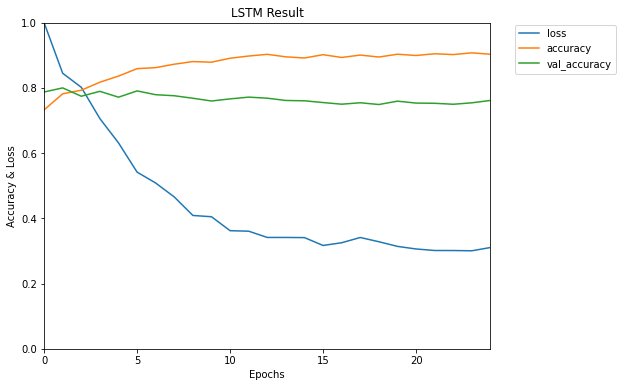

In [265]:
plt.figure(figsize=(8,6))
plt.xlabel("Epochs")
plt.ylabel("Accuracy & Loss")
x_len=list(range(len(acc)))
plt.axis([0, max(x_len), 0, 1])
plt.title('LSTM Result')
loss=np.asarray(loss)/max(loss)
plt.plot(x_len, loss,label="loss")
plt.plot(x_len, acc, label="accuracy")
plt.plot(x_len, val_acc, label="val_accuracy")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.2)
plt.show